# Poprawa współczynników filtru 
---
<p align="center">
    <img src="./doc/img/FIR.png", width = "500px">
</p>

## Wykorzystywane funkcje
 

In [107]:
import numpy as np

def db_to_linear(db: float):
    return 10**(db / 20)


def normalize_filter(filter_params):
    filter_norm = filter_params.copy()
    filter_norm['f_pass']  = ( filter_norm['f_pass']  / (0.5 * filter_norm['fs']) ) * np.pi
    filter_norm['tr_band'] = ( filter_norm['tr_band'] / (0.5 * filter_norm['fs']) ) * np.pi
    filter_norm['fs']      = np.pi

    return filter_norm

## Funkcja kosztów

In [127]:
import numpy as np
    

def cost_LP_filter(
    f_response: np.ndarray, 
    d1: float, 
    d2: float, 
    f_pass: float, 
    transition_band: float = 0):

    N_fft = f_response.shape[0]
    n_passband = int(np.ceil((f_pass * N_fft) / np.pi))
    n_transition = int(np.ceil(((f_pass + transition_band) * N_fft) / np.pi))
    
    cost = 0.
    # Passband section (in linear best = 1)
    d_sqr = (f_response[:n_passband-1] - 1)**2
    cost += np.sum(np.where(d_sqr > d1**2, np.sqrt(d_sqr), 0))

    # Stopband section (in linear best = 0)
    const_penalty = 10
    d = (f_response[n_transition:] - d2)
    cost += np.sum(np.where(d > 0., const_penalty*d, 0)) 

    return cost


## Funkcja wyświetlająca

In [109]:
import matplotlib.pyplot as plt

def display_LP_filter(f, f_response, filter_params):
    """_summary_

    Args:
        f (_type_): _description_
        f_response (_type_): _description_
        filter_params (_type_): _description_
    """

    d1 = filter_params['d1_db']
    d2 = filter_params['d2_db']
    f_pass  = filter_params['f_pass']
    tr_band = filter_params['tr_band']
    m_order = filter_params['m_order']

    # Draw limits
    plt.hlines(-d1, 0,              f_pass, linestyles='dashed', colors='g')
    plt.hlines(+d1, 0,              f_pass, linestyles='dashed', colors='g', label='Expected: A_pass')
    plt.hlines(d2 , f_pass+tr_band, np.pi , linestyles='dashed', colors='r', label='Expected: A_stop')
 
    # Draw filter response
    labels = ['Original  filter', 'Modified filter']
    for i in range(f.shape[0]):
        plt.plot(f[i], 20*np.log10(abs(f_response[i])), label=labels[i]) 
    
    plt.xlim([0, np.pi])
    plt.ylim([-100, 5])
    plt.legend()
    plt.title("FIR filter, M={}".format(m_order))
    plt.show()

## Wyznaczanie parametrów filtru

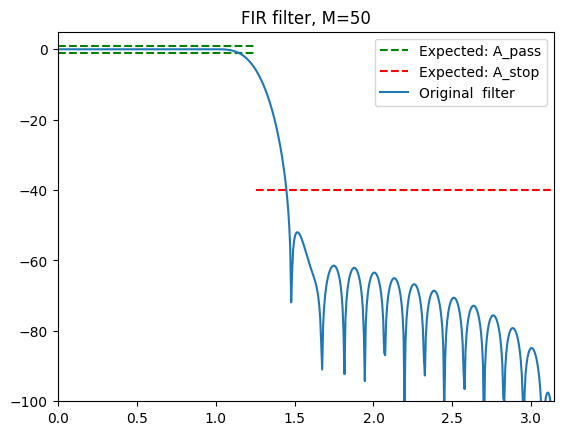

Initial value cost function: 61.323709036643486 


In [150]:
from scipy import signal
import numpy as np

# Parametry filtru
filter = {
    'N_fft':   512,
    'm_order': 50,
    'fs':      48e3,
    'f_pass':  9.6e3,
    'tr_band': 0.0e3,
    'd1_db':   1,
    'd2_db':   -40,
}

# Normalize filter 
filter_n = normalize_filter(filter)

# Współczynniki filtru metoda okienkowa
coef     = signal.firwin(filter['m_order'], filter['f_pass'], fs=filter['fs'], window='hamming')
f, f_res = signal.freqz(coef, worN=filter['N_fft'])

# Wyświetlenie parametrów filtru
display_LP_filter(f[np.newaxis,:], f_res[np.newaxis,:], filter_n)

# Domyślna wartość funkcji kosztu
cost_val = cost_LP_filter(abs(f_res), db_to_linear(filter_n['d1_db'])-1, db_to_linear(filter_n['d2_db']), filter_n['f_pass'], filter_n['tr_band'])
print("Initial value cost function: {} ".format(cost_val))

## Poprawa parametrów filtru metodami przeszukiwania sąsiedztwa

In [145]:
import numpy as np
import random

def slope_parameters(start_res, final_res, iter):
    return (final_res / start_res) ** (1 / iter)
    

def rvns_con(
    coef: np.ndarray, 
    filter_n: dict, 
    k_max: int = 1000, 
    k_sub_max: int = 300,
    return_hist=False):

    # Current solution
    _, f_res  = signal.freqz(coef, worN=filter['N_fft'])
    cost_curr = cost_LP_filter(abs(f_res), db_to_linear(filter_n['d1_db'])-1, db_to_linear(filter_n['d2_db']), filter_n['f_pass'], filter_n['tr_band'])
    coef_curr = coef.copy()

    # Best solution (in first step is the same as current)
    cost_best = cost_curr
    coef_best = coef_curr.copy()

    # Resolution
    sigma_prime_range = {
        'start': 1e-3,
        'final': 1e-6,
    }

    sigma_bis_range = {
        'start': 1e-3,
        'final': 1e-6,
    }

    sigma_prime = sigma_prime_range['start']
    sigma_bis   = sigma_bis_range['start']

    lmb_prime = slope_parameters(sigma_prime_range['start'], sigma_prime_range['final'], k_max)
    lmb_bis   = slope_parameters(sigma_bis_range['start'], sigma_bis_range['final'], k_sub_max)

    # Main part
    for i in range(k_max):
        # Update new coef
        idx_prime = np.random.randint(0, coef.shape[0])
        coef_prime = coef_curr.copy()
        coef_prime[idx_prime] += sigma_prime * np.random.randn()

        # For bis search
        cost_bis_min = 1e6
        for j in range(k_sub_max):
            idx_bis = np.random.randint(0, coef.shape[0])

            coef_bis = coef_prime.copy()
            coef_bis[idx_bis] += sigma_bis * np.random.randn()

            _, f_res  = signal.freqz(coef_bis, worN=filter['N_fft'])
            cost_bis = cost_LP_filter(abs(f_res), db_to_linear(filter_n['d1_db'])-1, db_to_linear(filter_n['d2_db']), filter_n['f_pass'], filter_n['tr_band'])
        
            if cost_bis < cost_bis_min:
                cost_bis_min = cost_bis
                coef_bis_min = coef_bis.copy()
        
            # Update resolution
            sigma_prime = lmb_prime * sigma_prime

        if cost_bis_min < cost_best:
            cost_best = cost_bis_min
            coef_best = coef_bis_min.copy()

        if cost_bis_min < cost_curr:
            cost_curr = cost_bis_min
            coef_curr = coef_bis_min.copy()           

        # Update resolution
        sigma_bis = lmb_bis * sigma_bis

    return cost_best, coef_best

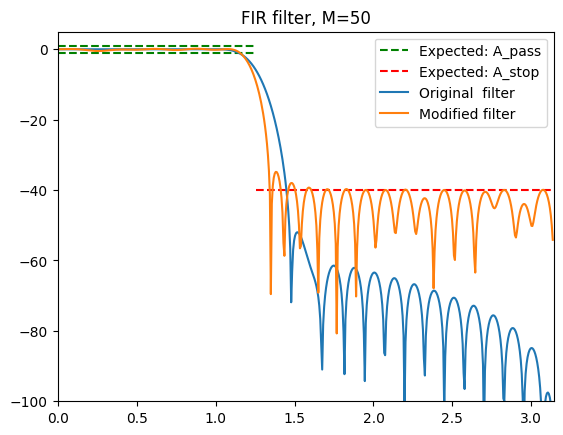

In [152]:
cost_best, coef_best = rvns_con(coef, filter_n)
f_b, f_res_b = signal.freqz(coef_best, worN=filter['N_fft'])
display_LP_filter(np.append(f[np.newaxis,:], f_b[np.newaxis,:], axis=0), 
                  np.append(f_res[np.newaxis,:], f_res_b[np.newaxis,:], axis=0 ), filter_n)

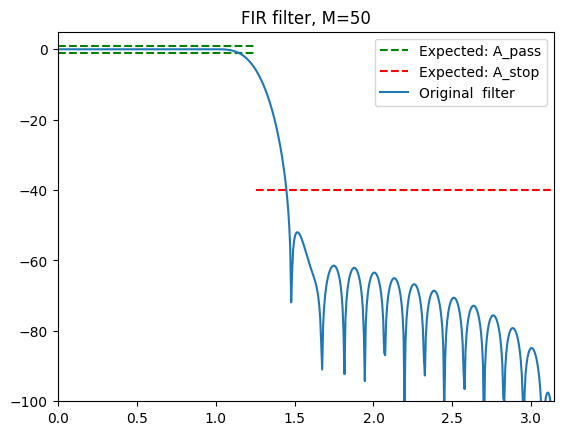

Initial value cost function: 61.323709036643486 


In [1]:
from filter import filter_utils
from scipy import signal
import numpy as np

# Parametry filtru
filter = {
    'N_fft':   512,
    'm_order': 50,
    'fs':      48e3,
    'f_pass':  9.6e3,
    'tr_band': 0.0e3,
    'd1_db':   1,
    'd2_db':   -40,
}

# Normalize filter
filter_n = filter_utils.normalize_filter (filter)

# Współczynniki filtru metoda okienkowa
coef     = signal.firwin(filter['m_order'], filter['f_pass'], fs=filter['fs'], window='hamming')
f, f_res = signal.freqz(coef, worN=filter['N_fft'])

# Wyświetlenie parametrów filtru
filter_utils.display_LP_filter(f[np.newaxis,:], f_res[np.newaxis,:], filter_n)

# Domyślna wartość funkcji kosztu
cost_val = filter_utils.cost_LP_filter(abs(f_res), filter_utils.db_to_linear(filter_n['d1_db'])-1, filter_utils.db_to_linear(filter_n['d2_db']), filter_n['f_pass'], filter_n['tr_band'])
print("Initial value cost function: {} ".format(cost_val))

In [2]:
from filter import filter_utils
from filter import rvns_filter

cost_best, coef_best = rvns_filter.rvns_con(coef, filter_n)



TypeError: 'type' object is not subscriptable